In [36]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #Quita los largos mensajes de error

plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

## Estrategia usando un RSI
###### Compramos acciones cuando  el valor de RSI supera el valor de 40
###### Vendemos cuando RSI cruza hacia abajo el nivel de 70

1. Import the libraries:

In [8]:
import pandas as pd 
import yfinance as yf
import backtrader as bt
import datetime
import matplotlib.pyplot as plt

2. The template of the strategy looks like:

In [3]:
class RSI_Strategy(bt.Strategy):
    params = dict(rsi_periods=14, rsi_upper=70, 
                  rsi_lower=40, rsi_mid=60)


    def __init__(self):
        # Seguimos los valores d e cierre uy apaertura de la serie
        self.data_close = self.datas[0].close
        self.data_open = self.datas[0].open

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # initializing rsi
        self.rsi = bt.indicators.RSI(self.data.close, period=self.p.rsi_periods) 
        
        # Tambien se pueden definir las bandas dentro del indicador
            #rsi = bt.indicators.RSI(period=self.p.rsi_periods,
                                #upperband=self.p.rsi_upper,
                                #lowerband=self.p.rsi_lower)
        
        #Señales de comprar y vender
        self.rsi_signal_long_buy = bt.ind.CrossUp(self.rsi, self.p.rsi_lower)
        self.rsi_signal_short = bt.ind.CrossDown(self.rsi, self.p.rsi_upper)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(
                    f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        # pnl (float): current profit and loss of the trade (gross pnl)
        # onlcomm, teniendo en cuenta comisión
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    def next_open(self):
        if not self.position:
            if self.rsi_signal_long_buy > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            #if self.rsi_signal_long_exit > 0:
            if self.rsi_signal_short > 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

3. Download data:

In [4]:
data = bt.feeds.PandasData(dataname=yf.download('MSFT', '2018-01-01', '2020-12-31'))

[*********************100%%**********************]  1 of 1 completed


4. Set up the backtest:

In [5]:
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)

cerebro.addstrategy(RSI_Strategy)
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addobserver(bt.observers.BuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')

5. Run the backtest:

In [6]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
2018-02-12, BUY CREATED --- Size: 112, Cash: 10000.00, Open: 88.73999786376953, Close: 89.12999725341797
2018-02-12, BUY EXECUTED --- Price: 88.74, Cost: 9938.88, Commission: 9.94
2018-06-08, SELL CREATED --- Size: 112
2018-06-08, SELL EXECUTED --- Price: 101.09, Cost: 9938.88, Commission: 11.32
2018-06-08, OPERATION RESULT --- Gross: 1383.20, Net: 1361.94
2018-10-15, BUY CREATED --- Size: 104, Cash: 11361.94, Open: 108.91000366210938, Close: 107.5999984741211
2018-10-15, BUY EXECUTED --- Price: 108.91, Cost: 11326.64, Commission: 11.33
2019-03-25, SELL CREATED --- Size: 104
2019-03-25, SELL EXECUTED --- Price: 116.56, Cost: 11326.64, Commission: 12.12
2019-03-25, OPERATION RESULT --- Gross: 795.60, Net: 772.15
2019-06-05, BUY CREATED --- Size: 97, Cash: 12134.09, Open: 124.94999694824219, Close: 125.83000183105469
2019-06-05, BUY EXECUTED --- Price: 124.95, Cost: 12120.15, Commission: 12.12
2019-06-26, SELL CREATED --- Size: 97
2019-06-26, SELL EXECU

6. Plot the results:

<IPython.core.display.Javascript object>


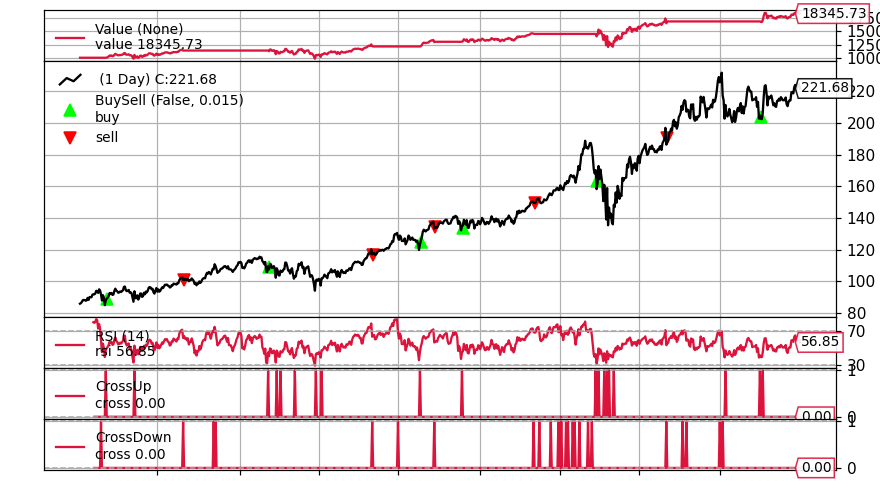

[[<Figure size 800x450 with 5 Axes>]]

In [7]:
cerebro.plot(iplot=True, volume=False)

7. Run to investigate different returns metrics:

In [48]:
print(backtest_result[0].analyzers.returns.get_analysis())

OrderedDict([('rtot', 0.6068117708936486), ('ravg', 0.0008037241998591372), ('rnorm', 0.22450722574000323), ('rnorm100', 22.450722574000324)])


8. Create a plot of daily portfolio returns:

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 125
warnings.simplefilter(action='ignore', category=FutureWarning)

<IPython.core.display.Javascript object>


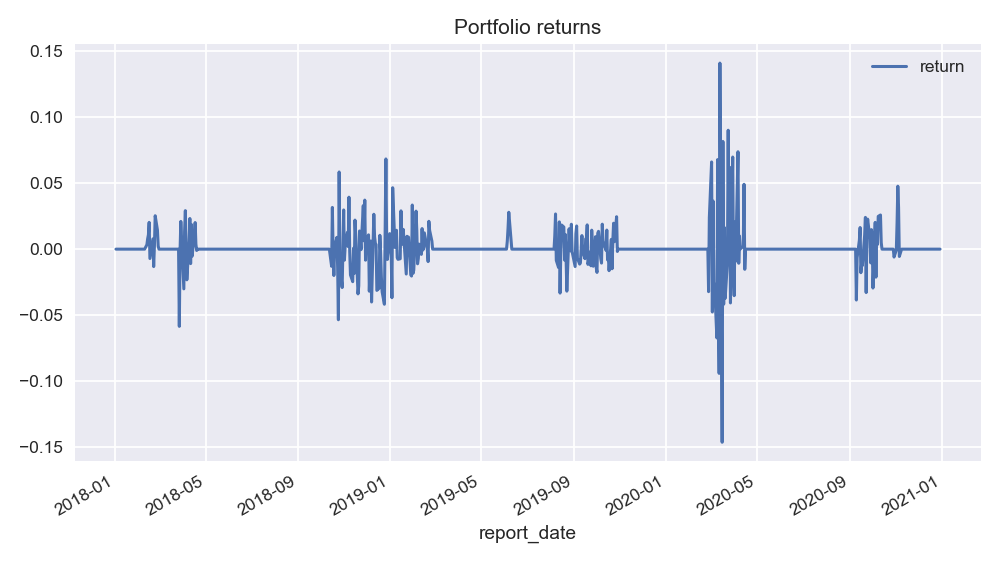

In [56]:
returns_dict = backtest_result[0].analyzers.time_return.get_analysis()
returns_df = pd.DataFrame(list(returns_dict.items()), 
                          columns = ['report_date', 'return']) \
               .set_index('report_date')
returns_df.plot(title='Portfolio returns')

plt.tight_layout()
# plt.savefig('images/ch2_im9.png')
plt.show()